# Project 5: Identifying High Risk Areas from NYC Traffic Conditions
## *Template Notebook*

In this notebook:

* [Topic 1](#topic-1)
* [Topic 2](#topic-2)

#### Import Libraries & Read in Data

In [2]:
## standard imports 
import pandas as pd 
import numpy as np
import re
## visualizations
import matplotlib.pyplot as plt
import seaborn as sns
## preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.dummy import DummyClassifier
## modeling
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
## trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor
## NLP
from sklearn.feature_extraction.text import CountVectorizer
## analysis
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, make_scorer, f1_score, mean_squared_error, mean_absolute_error

### statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

## options
import sklearn
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 100
pd.set_option('max_colwidth', 100)

In [23]:
### read in data
df18 = pd.read_csv('./data/crash_features_2018_cleaned.csv', index_col=0)
df19 = pd.read_csv('./data/crash_features_2019_cleaned.csv', index_col=0)

In [18]:
df18.head()

,CRASHES
2018-01-01,435
2018-01-02,610
2018-01-03,619
2018-01-04,439
2018-01-05,676


In [5]:
df18.shape

(365, 1)

## Topic 1 <a class="anchor" id="topic-1"></a>
<hr/>

Text(0.5, 1.0, 'Crashes per day 2018')

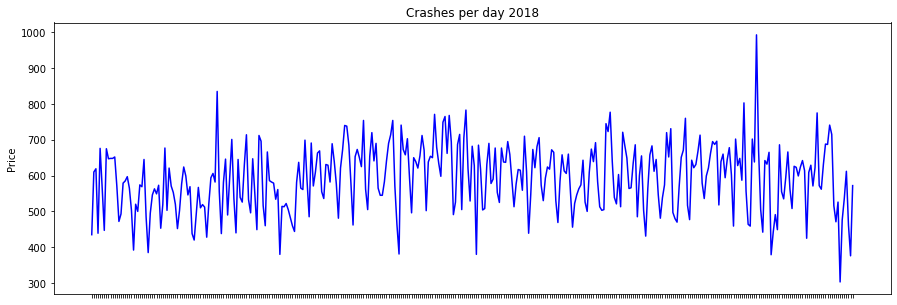

In [12]:
plt.figure(figsize=(15,5))
plt.plot(df18.index, df18['CRASHES'], c='blue')
# plt.plot(test.index, test['price'], c='red')
plt.tick_params(labelbottom=False)
plt.ylabel('Price')
plt.title('Crashes per day 2018')

### Add in Lag

In [40]:
# df18['lag_1'] = df18['CRASHES'].shift(1)
# df19['lag_1'] = df19['CRASHES'].shift(1)
# df18.head()

,CRASHES,lag_1
2018-01-01,435,NaN
2018-01-02,610,435.0
2018-01-03,619,610.0
2018-01-04,439,619.0
2018-01-05,676,439.0


In [24]:
lag_features = {i: f'lag_{i}' for i in [1,7,30]}

In [25]:
for i, feature_name in lag_features.items():
    df18[feature_name] = df18['CRASHES'].shift(i)

In [28]:
df18.head(40)

,CRASHES,lag_1,lag_7,lag_30
2018-01-01,435,NaN,NaN,NaN
2018-01-02,610,435.0,NaN,NaN
2018-01-03,619,610.0,NaN,NaN
2018-01-04,439,619.0,NaN,NaN
2018-01-05,676,439.0,NaN,NaN
2018-01-06,565,676.0,NaN,NaN
2018-01-07,447,565.0,NaN,NaN
2018-01-08,675,447.0,435.0,NaN
2018-01-09,647,675.0,610.0,NaN
2018-01-10,648,647.0,619.0,NaN


In [29]:
### drop na columns for modeling
df18.dropna(inplace=True)

In [30]:
df18.head()

,CRASHES,lag_1,lag_7,lag_30
2018-01-31,563,546.0,574.0,435.0
2018-02-01,549,563.0,569.0,610.0
2018-02-02,573,549.0,645.0,619.0
2018-02-03,453,573.0,485.0,439.0
2018-02-04,520,453.0,385.0,676.0


## Baseline Model <a class="anchor" id="topic-2"></a>
<hr/>

In [33]:
df18['CRASHES'].mean()

595.7283582089552

## Linear Regression <a class="anchor" id="topic-2"></a>
<hr/>

In [31]:
### Set up test and train data
# X_train = df18.drop(columns=['lag_1'])
# y_train = df18['lag_1']
# X_test = df19.drop(columns=['lag_1'])
# y_test = df19['lag_1']

X = df18.drop(columns=['CRASHES'])
y = df18['CRASHES']

In [32]:
### using statsmodels like in time series lesson part 4
X = sm.add_constant(X)
lm = sm.OLS(y, X).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CRASHES   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     37.83
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           4.82e-21
Time:                        11:20:55   Log-Likelihood:                -1940.2
No. Observations:                 335   AIC:                             3888.
Df Residuals:                     331   BIC:                             3904.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        279.7501     45.923      6.092      0.000     189.413     370.087
lag_1          0.2149      0.050      4.314      0.000       0.117       0.313
lag_7          0.4076      0.050      8.121      0.000       0.309       0.506
lag_30        -0.0931      0.049     -1.886      0.060      -0.190       0.004
==============================================================================
Omnibus:                       33.815   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.316
Skew:                          -0.075   Prob(JB):                     8.52e-39
Kurtosis:                       6.541   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

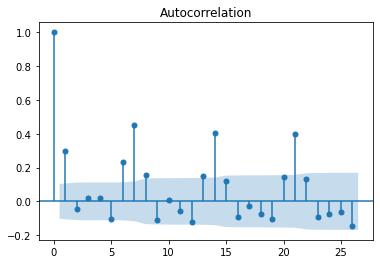

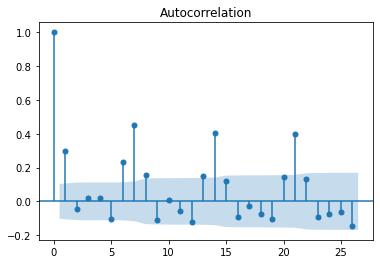

In [27]:
plot_acf(df18['CRASHES'])

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [45]:
y_preds = lr.predict(X_test)

In [46]:
print('R2 Score: ', lr.score(X_train, y_train))

R2 Score:  0.08736782721948011


In [47]:
print('R2 Score: ', lr.score(X_test, y_test))

R2 Score:  0.08736782721948011
